##### Copyright 2020 The TensorFlow IO Authors.

# Robust machine learning on streaming data using Kafka and Tensorflow-IO

## Steps :

1. Take the Dataset
2. Split the Dataset
3. Store the train and test data in Kafka
4. <b>Stream Data</b> from <b>Kafka to TensorFlow ( to train Online & test on live Data)</b>

## Overview

- <b> This tutorial focuses on streaming data from a [Kafka](https://kafka.apache.org/quickstart) cluster into a `tf.data.Dataset` which is then used in conjunction with `tf.keras` for training and inference. </b>

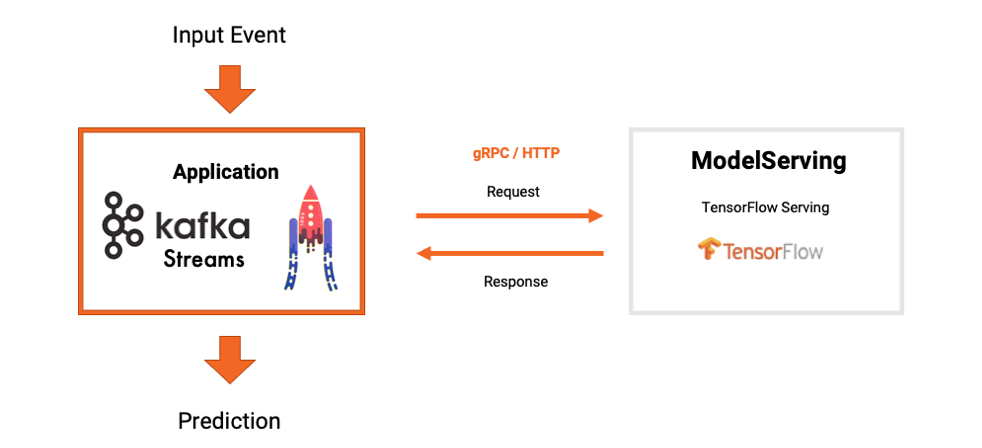

- Kafka is primarily a <b> distributed event-streaming platform which provides scalable and fault-tolerant streaming data across data pipelines.</b> It is an essential technical component of a plethora of major enterprises where mission-critical data delivery is a primary requirement.

**NOTE:** A basic understanding of the [kafka components](https://kafka.apache.org/documentation/#intro_concepts_and_terms) will help you in following the tutorial with ease.

**NOTE:** A Java runtime environment is required to run this tutorial.

## Setup

### Install the required tensorflow-io and kafka packages

In [ ]:
!pip install tensorflow-io
!pip install kafka-python

     |████████████████████████████████| 23.4 MB 59.9 MB/s 
     |████████████████████████████████| 246 kB 5.4 MB/s 


### Import packages

In [ ]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

### Validate tf and tfio imports

In [ ]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.24.0
tensorflow version: 2.8.0


## Download and setup Kafka and Zookeeper instances

For demo purposes, the following instances are setup locally:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)

<b> ZooKeeper </b>  is primarily used to track the status of nodes in the Kafka cluster and maintain a list of Kafka topics and messages.

A <b> Kafka server, a Kafka broker and a Kafka node </b> all refer to the same concept and are synonyms

<b> broker : </b> A broker is an individual person who arranges transactions between a buyer and a seller for a commission when the deal is executed.

<b> Kafka broker :</b> 

- A Kafka broker <b>receives messages from producers and stores them on disk </b> keyed by unique offset.
- A Kafka broker <b>allows consumers to fetch messages by topic, partition and offset.</b>
- Kafka brokers can <b> create a Kafka cluster by sharing information between each other directly or indirectly using Zookeeper.</b>
-A Kafka cluster has exactly one broker that acts as the Controller.
- <b> You can start a single Kafka broker using kafka-server-start.sh script.</b>

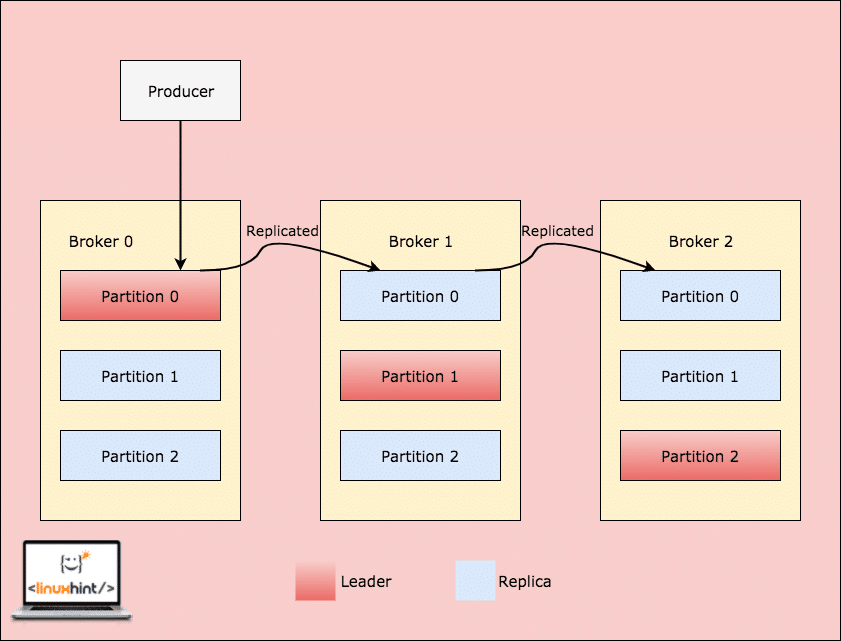


In [ ]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.1.0/kafka_2.13-3.1.0.tgz # curl is a command-line tool to transfer data to or from a server, using any of the supported protocols (HTTP, FTP etc)
!tar -xzf kafka_2.13-3.1.0.tgz

Using the default configurations (provided by Apache Kafka) for <b>spinning up the instances.</b>

In [ ]:
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Once the instances are started as daemon processes, grep for `kafka` in the processes list.<b> The two java processes correspond to zookeeper and the kafka instances.</b>

In [ ]:
!ps -ef | grep kafka

root         513       1 10 03:16 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.1.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.1.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.1.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.1.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

<b>Create</b> the kafka topics with the following specs:

- susy-train: partitions=1, replication-factor=1 
- susy-test: partitions=2, replication-factor=1 

In [ ]:
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic susy-train
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic susy-test


Created topic susy-train.
Created topic susy-test.


<b>Describe</b> the topic for details on the configuration

In [ ]:
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-train
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-test


Topic: susy-train	TopicId: t1Rx1ujUSxS1Lxce8wXHlQ	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: susy-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: susy-test	TopicId: nCne6YaaQ2SrYNWfj7tdHw	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: susy-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: susy-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


<b> The replication factor 1 indicates that the data is not being replicated. This is due to the presence of a single broker in our kafka setup.</b>
In production systems, the number of bootstrap servers can be in the range of 100's of nodes. That is where the fault-tolerance using replication comes into picture.

Please refer to the [docs](https://kafka.apache.org/documentation/#replication) for more details.


## SUSY Dataset

Kafka being an event streaming platform, enables  data from various sources to be written into it. For instance:

- Web traffic logs
- Astronomical measurements
- IoT sensor data
- Product reviews and many more.

For the purpose of this tutorial, lets download the [SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY#) dataset and feed the data into kafka manually. The goal of this <b> classification problem </b> is to distinguish between a signal process which produces <b> supersymmetric particles(1) and a background process(0) which does not.</b>

- <b> to help discriminate between the two classes of particles (1 , 0), given 18 features. </b>


In [ ]:
!curl -sSOL https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

### Explore the dataset

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features).
- <b> The first 8 features are kinematic properties measured by the particle detectors in the accelerator.</b> 

- <b>  The last 10 features are functions of the first 8 features. These are high-level features derived by physicists to help discriminate between the two classes.</b>

In [ ]:
COLUMNS = [
          #  labels
           'class',
          #  low-level features
           'lepton_1_pT',
           'lepton_1_eta',
           'lepton_1_phi',
           'lepton_2_pT',
           'lepton_2_eta',
           'lepton_2_phi',
           'missing_energy_magnitude',
           'missing_energy_phi',
          #  high-level derived features
           'MET_rel',
           'axial_MET',
           'M_R',
           'M_TR_2',
           'R',
           'MT2',
           'S_R',
           'M_Delta_R',
           'dPhi_r_b',
           'cos(theta_r1)'
           ]

The entire dataset consists of 5 million rows. However, for the purpose of this tutorial, let's consider only a fraction of the dataset (100,000 rows) so that less time is spent on the moving the data and more time on understanding the functionality of the api.

In [ ]:
susy_iterator = pd.read_csv('SUSY.csv.gz', header=None, names=COLUMNS, chunksize=100000)
susy_df = next(susy_iterator) # next() method returns the current row and advances the iterator to the next row.
susy_df.head()

,class,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [ ]:
# Number of datapoints and columns
len(susy_df), len(susy_df.columns)

(100000, 19)

In [ ]:
# Number of datapoints belonging to each class (0: background process, 1: particle)
len(susy_df[susy_df["class"]==0]), len(susy_df[susy_df["class"]==1])

(54025, 45975)

### Split the dataset


In [ ]:
train_df, test_df = train_test_split(susy_df, test_size=0.4, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

x_train_df = train_df.drop(["class"], axis=1)
y_train_df = train_df["class"]

x_test_df = test_df.drop(["class"], axis=1)
y_test_df = test_df["class"]

# The labels are set as the kafka message keys so as to store data
# in multiple-partitions. Thus, enabling efficient data retrieval
# using the consumer groups.
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:])) # split() method splits csv file into a list without writing row names
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:])) # stop splitting after you meet the separator \n once

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))


Number of training samples:  60000
Number of testing sample:  40000


In [ ]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

(60000, 60000, 40000, 40000)

### Store / <b> Write </b>the train and test data in kafka

<b>Storing the data in kafka simulates an environment for continuous remote data retrieval for training and inference purposes.</b>

In [ ]:
def error_callback(exc):  # exception handling :  if error occurs during sending data to Kafka
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092']) # A Kafka client that publishes records to the Kafka cluster
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback) # it adds the record to a buffer of pending record sends and immediately returns.
    count+=1
  producer.flush() #  Wait for all messages in the Producer queue to be delivered
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("susy-train", zip(x_train, y_train))
write_to_kafka("susy-test", zip(x_test, y_test))


Wrote 60000 messages into topic: susy-train
Wrote 40000 messages into topic: susy-test


### Define the tfio train dataset

<b> The `IODataset` class is utilized for streaming data from kafka into tensorflow. </b>The class inherits from <b>`tf.data.Dataset`</b> and thus has all the useful functionalities of <b>`tf.data.Dataset` </b>out of the box.


In [ ]:
def decode_kafka_item(item):
  message = tf.io.decode_csv(item.message, [[0.0] for i in range(NUM_COLUMNS)]) # Convert CSV records to tensors. Each column maps to one tensor.
  key = tf.strings.to_number(item.key) # Converts each string in the input Tensor to the specified numeric type
  return (message, key)

BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=64
train_ds = tfio.IODataset.from_kafka('susy-train', partition=0, offset=0) # Kafka maintains a numerical offset for each record in a partition
train_ds = train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.map(decode_kafka_item) # a new disb. dataset of type (message , key) will be returned
train_ds = train_ds.batch(BATCH_SIZE)

## Build and train the model


In [ ]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=10


In [ ]:
# design/build the model
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(NUM_COLUMNS,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
# fit the model
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


938/938 [==============================] - 39s 34ms/step - loss: 0.4838 - accuracy: 0.7693
Epoch 2/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4559 - accuracy: 0.7879
Epoch 3/10
938/938 [==============================] - 33s 34ms/step - loss: 0.4511 - accuracy: 0.7908
Epoch 4/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4487 - accuracy: 0.7915
Epoch 5/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4471 - accuracy: 0.7928
Epoch 6/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4461 - accuracy: 0.7927
Epoch 7/10
938/938 [==============================] - 33s 35ms/step - loss: 0.4461 - accuracy: 0.7936
Epoch 8/10
938/938 [==============================] - 31s 33ms/step - loss: 0.4459 - accuracy: 0.7932
Epoch 9/10
938/938 [==============================] - 33s 35ms/step - loss: 0.4439 - accuracy: 0.7953
Epoch 10/10
938/938 [==============================] - 31s 33ms/step - loss: 0.4424 - accurac

Note: Please do not confuse the training step with online training. It's an entirely different paradigm which will be covered in a later section.

Since only a fraction of the dataset is being utilized, our accuracy is limited to ~78% during the training phase. However, please feel free to store additional data in kafka for a better model performance. Also, since the goal was to just demonstrate the functionality of the tfio kafka datasets, a smaller and less-complicated neural network was used. However, one can increase the complexity of the model, modify the learning strategy, tune hyper-parameters etc for exploration purposes. For a baseline approach, please refer to this [article](https://www.nature.com/articles/ncomms5308#Sec11).

## Infer on the test data

To infer on the test data by adhering to the 'exactly-once' semantics along with fault-tolerance, the <b> `streaming.KafkaGroupIODataset`</b> can be utilized. 

<b> tfio.experimental.streaming.KafkaGroupIODataset </b>

- <b>Represents a streaming dataset from kafka using consumer groups to TensorFlow.</b>

source : https://www.tensorflow.org/io/api_docs/python/tfio/experimental/streaming/KafkaGroupIODataset





### Define the tfio test dataset

- <b>The `stream_timeout`</b> parameter blocks for the given duration for <b> NEW DATA POINTS </b> to be streamed into the topic. 

- This removes the need for creating new datasets if the data is being streamed into the topic in an intermittent fashion.

- <b>session.timeout.ms </b> is for the heartbeat thread and <b>max.poll.interval.ms</b> is for the processing thread.

- Kafka checked the heartbeats of the consumer and calls to poll() using session.timeout.ms and it was tightly coupled.

Source:https://upokary.com/difference-between-session-timeout-ms-and-max-poll-interval-ms-for-kafka/ 

In [ ]:
test_ds = tfio.experimental.streaming.KafkaGroupIODataset( # The dataset is getting prepared and iterated in the following manner in Kafka
    topics=["susy-test"],
    group_id="testcg",
    servers="127.0.0.1:9092",
    stream_timeout=10000,
    configuration=[                           # to process messgage at Consumers, you have to set these time manually for different threads
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

def decode_kafka_test_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

test_ds = test_ds.map(decode_kafka_test_item)
test_ds = test_ds.batch(BATCH_SIZE)

Instructions for updating:
Use `tf.data.Dataset.take_while(...)


Though this class can be used for training purposes, there are caveats which need to be addressed. <b> Once all the messages are read from kafka and the latest offsets are committed using the `streaming.KafkaGroupIODataset`, the consumer doesn't restart reading the messages from the beginning. Thus, while training, it is possible only to train for a single epoch with the data continuously flowing in. </b>This kind of a functionality has limited use cases during the training phase wherein, once a datapoint has been consumed by the model it is no longer required and can be discarded.

However, this functionality shines when it comes to robust inference with exactly-once semantics.

### evaluate the performance on the Streamed test data


In [ ]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


625/625 [==============================] - 15s 23ms/step - loss: 0.4385 - accuracy: 0.7979
test loss, test acc: [0.43845707178115845, 0.7978749871253967]


Since the inference is based on 'exactly-once' semantics, the evaluation on the test set can be run only once. In order to run the inference again on the test data, a new consumer group should be used.

### Track the offset lag of the `testcg` consumer group

In [ ]:
!./kafka_2.13-3.1.0/bin/kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --describe --group testcg



Consumer group 'testcg' has no active members.

GROUP           TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID     HOST            CLIENT-ID
testcg          susy-test       0          21585           21585           0               -               -               -
testcg          susy-test       1          18415           18415           0               -               -               -


<b> Once the `current-offset` matches the `log-end-offset` for all the partitions, it indicates that the consumer(s) have completed fetching all the messages from the kafka topic.</b>

## Online learning

- The online machine learning paradigm is a bit different from the traditional/conventional way of training machine learning models. <b> In the former case, the model continues to incrementally learn/update it's parameters as soon as the new data points are available and this process is expected to continue indefinitely.</b> 

- This is unlike the latter approaches where the dataset is fixed and the model iterates over it `n` number of times. In online learning, the data once consumed by the model may not be available for training again.

- By utilizing the <b> `streaming.KafkaBatchIODataset`, it is now possible to train the models in this fashion. Let's continue to use our SUSY dataset for demonstrating this functionality.</b> 

### The tfio training dataset for online learning

- <b> The `streaming.KafkaBatchIODataset` </b> is similar to the `streaming.KafkaGroupIODataset` in it's API.

- <b>streaming.KafkaBatchIODataset :</b> enabling the user to train their model in an online learning fashion
-  Additionally, it is recommended to utilize the <b>`stream_timeout` </b>parameter to configure the duration for which the dataset will block for new messages before timing out.

-  In the instance below, the dataset is configured with a <b> `stream_timeout` of `10000` milliseconds. This implies that, after all the messages from the topic have been consumed, the dataset will wait for an additional 10 seconds before timing out and disconnecting from the kafka cluster.</b>  If new messages are streamed into the topic before timing out, the data consumption and model training resumes for those newly consumed data points. To block indefinitely, set it to `-1`.


Source : https://www.tensorflow.org/io/api_docs/python/tfio/experimental/streaming/KafkaBatchIODataset

In [ ]:
online_train_ds = tfio.experimental.streaming.KafkaBatchIODataset( # preparing dataset for online training / learning
    topics=["susy-train"],
    group_id="cgonline",
    servers="127.0.0.1:9092",
    stream_timeout=10000, # in milliseconds, to block indefinitely, set it to -1.
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

Every item that the <b> `online_train_ds` </b> generates is a <b>`tf.data.Dataset` </b>in itself. Thus, all the standard transformations can be applied as usual.


In [ ]:
def decode_kafka_online_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)
  
for mini_ds in online_train_ds:  # online training in with batch size 32 , somewhat similar to 'minibatch gradient descent' training
  mini_ds = mini_ds.shuffle(buffer_size=32)
  mini_ds = mini_ds.map(decode_kafka_online_item)
  mini_ds = mini_ds.batch(32)
  if len(mini_ds) > 0:
    model.fit(mini_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4447 - accuracy: 0.7923
Epoch 2/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4415 - accuracy: 0.7944
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4388 - accuracy: 0.7949
Epoch 1/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4485 - accuracy: 0.7946
Epoch 2/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4451 - accuracy: 0.7955
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4431 - accuracy: 0.7955
Epoch 1/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4472 - accuracy: 0.7938
Epoch 2/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4446 - accuracy: 0.7941
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4410 - accuracy: 0.7950
Epoch 1/3
313/313 [==============================] - 2s 7ms/step - loss: 0.4547 - accuracy: 0.7836
Epoch 2/3


The <b>incrementally trained model </b>can be saved in a periodic fashion (based on use-cases) and can be utilized to infer on the test data in either online or offline modes.

<b>Note: </b>The `streaming.KafkaBatchIODataset` and `streaming.KafkaGroupIODataset` are still in experimental phase and have scope for improvements based on user-feedback.

## References:

- Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014)

- SUSY Dataset: https://archive.ics.uci.edu/ml/datasets/SUSY#
